In [1]:
%load_ext nb_black
%load_ext autoreload

%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import os
from pathlib import Path

from requests import get
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import logging

logging.basicConfig(level=logging.WARN)

<IPython.core.display.Javascript object>

In [3]:
from xplainet.input_utils import preproc_dataset
from xplainet.model import build_model
from xplainet.random_utils import setup_seed, SEED
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

from zipfile import ZipFile

<IPython.core.display.Javascript object>

In [4]:
setup_seed()

<IPython.core.display.Javascript object>

In [5]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force and out.exists():
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)


<IPython.core.display.Javascript object>

In [6]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "AUC" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "AUC" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

## Bank marketing : loading data

In [7]:
dataset_name = "kaggle-house-prices"
out = Path(os.getcwd() + "/data/" + dataset_name + "-train.csv")

target = "SalePrice"
to_remove = []
train = pd.read_csv(out, sep=",", low_memory=False)

<IPython.core.display.Javascript object>

In [8]:
!ls data

census-income.csv	forest-cover-type.csv  kaggle-house-prices-test.csv
census-income_test.csv	forest-cover-type.zip  kaggle-house-prices-train.csv


<IPython.core.display.Javascript object>

In [9]:
train.shape

(1460, 81)

<IPython.core.display.Javascript object>

In [10]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

<IPython.core.display.Javascript object>

In [11]:
if "Set" not in train.columns:
    print("Building tailored column")
    train_valid_index, test_index = next(
        ShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            range(train[target].shape[0])
        )
    )
    train_index, valid_index = next(
        ShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            train_valid_index
        )
    )
    train["Set"] = "train"
    train["Set"][valid_index] = "valid"
    train["Set"][test_index] = "test"
    # train.to_csv((out.parent / "train_bench.csv").as_posix(), index=False)

Building tailored column


/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>

In [12]:
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

<IPython.core.display.Javascript object>

In [13]:
input_train, params = preproc_dataset(train.loc[train_indices], target, ["Set"])
params

{'constant_cols': [],
 'bool_cols': ['Alley', 'Utilities', 'CentralAir', 'Street'],
 'num_cols': ['BsmtFinSF1',
  'GarageYrBlt',
  'WoodDeckSF',
  '1stFlrSF',
  '2ndFlrSF',
  'BsmtUnfSF',
  'Id',
  'YearBuilt',
  'BsmtFinSF2',
  'EnclosedPorch',
  'GrLivArea',
  'OpenPorchSF',
  'MasVnrArea',
  'GarageArea',
  'LotArea',
  'YearRemodAdd',
  'LotFrontage',
  'TotalBsmtSF',
  'ScreenPorch'],
 'cat_cols': ['FullBath',
  'RoofStyle',
  'Exterior1st',
  'LotShape',
  'MSSubClass',
  'BsmtFinType1',
  'Condition2',
  'LandSlope',
  'GarageCars',
  'PoolQC',
  'TotRmsAbvGrd',
  'BsmtFullBath',
  'MSZoning',
  'HalfBath',
  'PavedDrive',
  'GarageFinish',
  'Exterior2nd',
  'LowQualFinSF',
  'HeatingQC',
  'MasVnrType',
  'Neighborhood',
  'GarageType',
  'RoofMatl',
  'MiscVal',
  'Functional',
  'HouseStyle',
  'BsmtExposure',
  'OverallQual',
  'Fence',
  'BsmtFinType2',
  'BedroomAbvGr',
  'GarageCond',
  'SaleType',
  'SaleCondition',
  'GarageQual',
  '3SsnPorch',
  'Foundation',
  'Kitc

<IPython.core.display.Javascript object>

In [14]:
len(train_indices)

1219

<IPython.core.display.Javascript object>

In [15]:
input_valid, _ = preproc_dataset(train.loc[valid_indices], target, ["Set"], params)
input_test, _ = preproc_dataset(train.loc[test_indices], target, ["Set"], params)

<IPython.core.display.Javascript object>

In [16]:
target_encoder = StandardScaler()

<IPython.core.display.Javascript object>

In [17]:
target_encoder.fit(train[target].values.reshape(-1, 1))
y_train = target_encoder.transform(train[target].values[train_indices].reshape(-1, 1))
y_valid = target_encoder.transform(train[target].values[valid_indices].reshape(-1, 1))
y_test = target_encoder.transform(train[target].values[test_indices].reshape(-1, 1))

<IPython.core.display.Javascript object>

In [18]:
params

{'constant_cols': [],
 'bool_cols': ['Alley', 'Utilities', 'CentralAir', 'Street'],
 'num_cols': ['BsmtFinSF1',
  'GarageYrBlt',
  'WoodDeckSF',
  '1stFlrSF',
  '2ndFlrSF',
  'BsmtUnfSF',
  'Id',
  'YearBuilt',
  'BsmtFinSF2',
  'EnclosedPorch',
  'GrLivArea',
  'OpenPorchSF',
  'MasVnrArea',
  'GarageArea',
  'LotArea',
  'YearRemodAdd',
  'LotFrontage',
  'TotalBsmtSF',
  'ScreenPorch'],
 'cat_cols': ['FullBath',
  'RoofStyle',
  'Exterior1st',
  'LotShape',
  'MSSubClass',
  'BsmtFinType1',
  'Condition2',
  'LandSlope',
  'GarageCars',
  'PoolQC',
  'TotRmsAbvGrd',
  'BsmtFullBath',
  'MSZoning',
  'HalfBath',
  'PavedDrive',
  'GarageFinish',
  'Exterior2nd',
  'LowQualFinSF',
  'HeatingQC',
  'MasVnrType',
  'Neighborhood',
  'GarageType',
  'RoofMatl',
  'MiscVal',
  'Functional',
  'HouseStyle',
  'BsmtExposure',
  'OverallQual',
  'Fence',
  'BsmtFinType2',
  'BedroomAbvGr',
  'GarageCond',
  'SaleType',
  'SaleCondition',
  'GarageQual',
  '3SsnPorch',
  'Foundation',
  'Kitc

<IPython.core.display.Javascript object>

In [19]:
model = build_model(
    params,
    lconv_dim=[4],
    lconv_num_dim=[8],
    emb_size=16,
    # For this problem, we need "tanh" as first layer, or else to standard scale the data beforehand
    activation_num_first_layer="tanh",
    output_activation=None,
    output_dim=1,  # np.unique(y_train).shape[0],
)

/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/options.py:47: RuntimeWarning: Traceback (most recent call last):
  File "/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/activations/mish.py", line 44, in mish
    return _mish_custom_op(x)
  File "/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/activations/mish.py", line 59, in _mish_custom_op
    return _activation_so.ops.addons_mish(x)
  File "/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/utils/resource_loader.py", line 64, in ops
    self._ops = tf.load_op_library(get_path_to_datafile(self.relative_path))
  File "/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow/python/framework/load_library.py", line 58, in load_op_library
    lib_handle = py_tf.TF_LoadLibrary(library_filename)
tensorflow.python.framework.errors_impl.NotFoundError: /

<IPython.core.display.Javascript object>

In [20]:
model.summary()

Model: "explainable_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_num (InputLayer)          [(None, 19)]         0                                            
__________________________________________________________________________________________________
input_cat (InputLayer)          [(None, 57)]         0                                            
__________________________________________________________________________________________________
reshape_num_input (Reshape)     (None, 19, 1)        0           input_num[0][0]                  
__________________________________________________________________________________________________
large_emb (Embedding)           (None, 57, 16)       432         input_cat[0][0]                  
__________________________________________________________________________________

<IPython.core.display.Javascript object>

In [21]:
#!pip install pydot graphviz

<IPython.core.display.Javascript object>

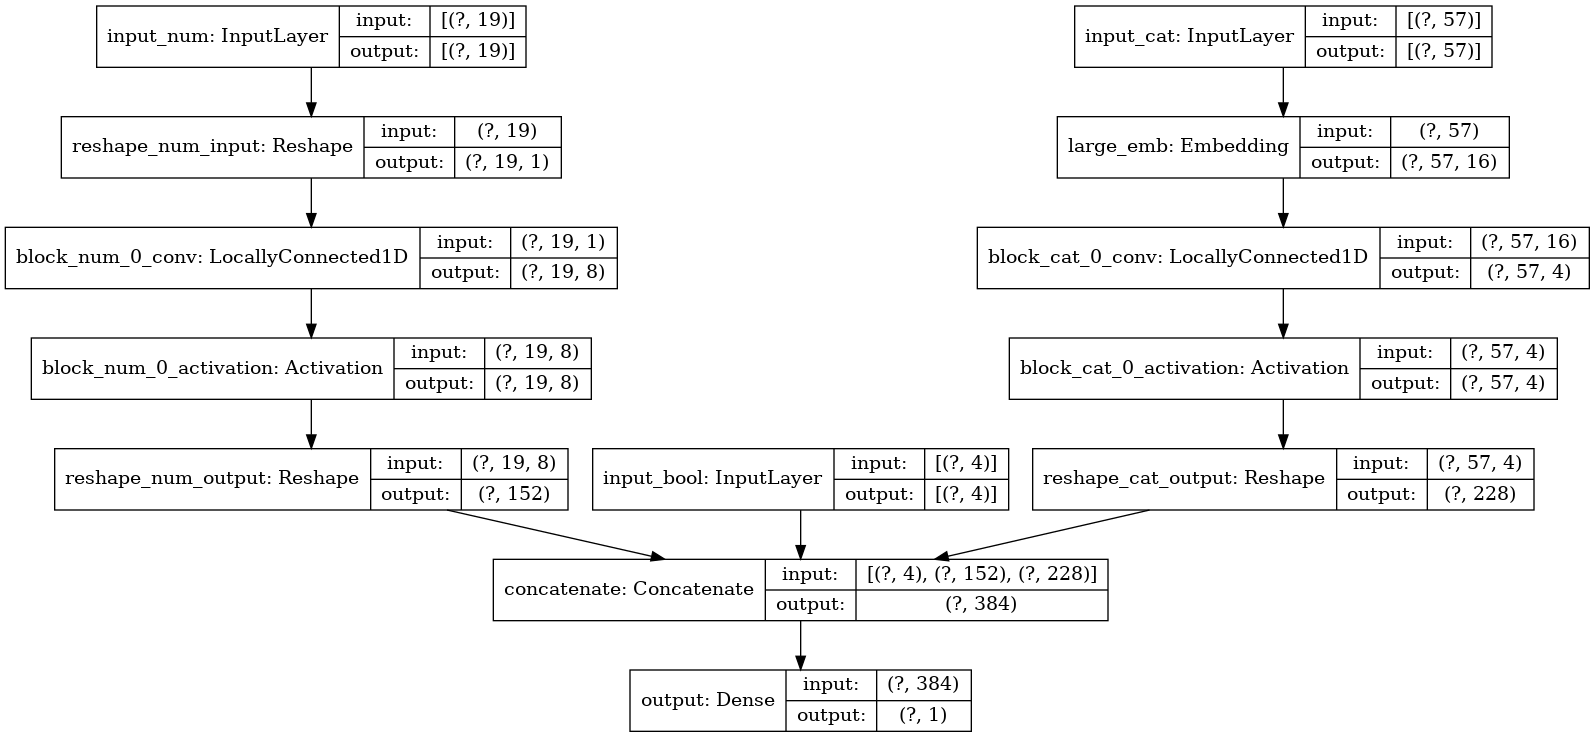

<IPython.core.display.Javascript object>

In [22]:
plot_model(
    model,
    # to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [23]:
y_train.shape

(1219, 1)

<IPython.core.display.Javascript object>

In [24]:
counts = np.unique(y_train, return_counts=True)[1]
counts = counts.sum() / counts

<IPython.core.display.Javascript object>

In [25]:
%%time
history = model.fit(
    input_train,
    y_train.reshape(-1, 1),
    epochs=2000,
    batch_size=1024,
    validation_data=(input_valid, y_valid.reshape(-1, 1),),
    verbose=2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=50, verbose=1)],
    #class_weight=None#class_weight
)

Epoch 1/2000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2/2 - 0s - loss: 1.2237 - val_loss: 1.1395
Epoch 2/2000
2/2 - 0s - loss: 1.0115 - val_loss: 1.0314
Epoch 3/2000
2/2 - 0s - loss: 0.9340 - val_loss: 1.0886
Epoch 4/2000
2/2 - 0s - loss: 0.9721 - val_loss: 1.0857
Epoch 5/2000
2/2 - 0s - loss: 0.9696 - val_loss: 1.0819
Epoch 6/2000
2/2 - 0s - loss: 0.9664 - val_loss: 1.0828
Epoch 7/2000
2/2 - 0s - loss: 0.9672 - val_loss: 1.0771
Epoch 8/2000
2/2 - 0s - loss: 0.9629 - val_loss: 1.0713
Epoch 9/2000
2/2 - 0s - loss: 0.9581 - val_loss: 1.0737
Epoch 10/2000
2/2 - 0s - loss: 0.9596 - val_loss: 1.0670
Epoch 11/2000
2/2 - 0s - loss: 0.9544 - val_loss: 1.0599
Epoch 12/2000
2/2 - 0s - loss: 0.9495 - val_loss: 1.0628
Epoch 13/2000
2/2 - 0s - loss: 0.9512 - val_loss: 1.0555
Epoch 14/2000
2/2 - 0s - loss: 0.9459 - val_loss: 1.0482
Epoch 15/2000
2/2 - 0s - loss: 0.9404 - val_loss: 1.0514
Epoch 16/2000
2/2 - 0s - loss: 0.9430 - val_loss: 1.0439
Epoch 17/2000
2/2 - 0s - loss: 0.9376 - val_loss: 1.0368
Epoch 18/2000
2/2 - 0s - loss: 0.9329 - val_loss: 1.0

Epoch 145/2000
2/2 - 0s - loss: 0.5587 - val_loss: 0.5687
Epoch 146/2000
2/2 - 0s - loss: 0.5509 - val_loss: 0.5582
Epoch 147/2000
2/2 - 0s - loss: 0.5429 - val_loss: 0.5636
Epoch 148/2000
2/2 - 0s - loss: 0.5468 - val_loss: 0.5543
Epoch 149/2000
2/2 - 0s - loss: 0.5388 - val_loss: 0.5448
Epoch 150/2000
2/2 - 0s - loss: 0.5306 - val_loss: 0.5499
Epoch 151/2000
2/2 - 0s - loss: 0.5349 - val_loss: 0.5420
Epoch 152/2000
2/2 - 0s - loss: 0.5269 - val_loss: 0.5309
Epoch 153/2000
2/2 - 0s - loss: 0.5185 - val_loss: 0.5349
Epoch 154/2000
2/2 - 0s - loss: 0.5227 - val_loss: 0.5247
Epoch 155/2000
2/2 - 0s - loss: 0.5151 - val_loss: 0.5146
Epoch 156/2000
2/2 - 0s - loss: 0.5066 - val_loss: 0.5204
Epoch 157/2000
2/2 - 0s - loss: 0.5100 - val_loss: 0.5205
Epoch 158/2000
2/2 - 0s - loss: 0.5080 - val_loss: 0.5114
Epoch 159/2000
2/2 - 0s - loss: 0.4991 - val_loss: 0.5084
Epoch 160/2000
2/2 - 0s - loss: 0.4992 - val_loss: 0.5002
Epoch 161/2000
2/2 - 0s - loss: 0.4924 - val_loss: 0.4923
Epoch 162/2000

2/2 - 0s - loss: 0.2032 - val_loss: 0.1952
Epoch 287/2000
2/2 - 0s - loss: 0.1996 - val_loss: 0.2002
Epoch 288/2000
2/2 - 0s - loss: 0.2011 - val_loss: 0.1942
Epoch 289/2000
2/2 - 0s - loss: 0.2001 - val_loss: 0.1927
Epoch 290/2000
2/2 - 0s - loss: 0.1984 - val_loss: 0.1913
Epoch 291/2000
2/2 - 0s - loss: 0.1967 - val_loss: 0.1925
Epoch 292/2000
2/2 - 0s - loss: 0.1970 - val_loss: 0.1934
Epoch 293/2000
2/2 - 0s - loss: 0.1950 - val_loss: 0.1949
Epoch 294/2000
2/2 - 0s - loss: 0.1957 - val_loss: 0.1918
Epoch 295/2000
2/2 - 0s - loss: 0.1944 - val_loss: 0.1900
Epoch 296/2000
2/2 - 0s - loss: 0.1933 - val_loss: 0.1892
Epoch 297/2000
2/2 - 0s - loss: 0.1915 - val_loss: 0.1901
Epoch 298/2000
2/2 - 0s - loss: 0.1921 - val_loss: 0.1887
Epoch 299/2000
2/2 - 0s - loss: 0.1903 - val_loss: 0.1884
Epoch 300/2000
2/2 - 0s - loss: 0.1894 - val_loss: 0.1890
Epoch 301/2000
2/2 - 0s - loss: 0.1899 - val_loss: 0.1895
Epoch 302/2000
2/2 - 0s - loss: 0.1886 - val_loss: 0.1888
Epoch 303/2000
2/2 - 0s - los

Epoch 428/2000
2/2 - 0s - loss: 0.1329 - val_loss: 0.1665
Epoch 429/2000
2/2 - 0s - loss: 0.1332 - val_loss: 0.1671
Epoch 430/2000
2/2 - 0s - loss: 0.1326 - val_loss: 0.1688
Epoch 431/2000
2/2 - 0s - loss: 0.1321 - val_loss: 0.1708
Epoch 432/2000
2/2 - 0s - loss: 0.1325 - val_loss: 0.1683
Epoch 433/2000
2/2 - 0s - loss: 0.1320 - val_loss: 0.1677
Epoch 434/2000
2/2 - 0s - loss: 0.1327 - val_loss: 0.1639
Epoch 435/2000
2/2 - 0s - loss: 0.1313 - val_loss: 0.1660
Epoch 436/2000
2/2 - 0s - loss: 0.1311 - val_loss: 0.1670
Epoch 437/2000
2/2 - 0s - loss: 0.1305 - val_loss: 0.1686
Epoch 438/2000
2/2 - 0s - loss: 0.1304 - val_loss: 0.1668
Epoch 439/2000
2/2 - 0s - loss: 0.1310 - val_loss: 0.1659
Epoch 440/2000
2/2 - 0s - loss: 0.1305 - val_loss: 0.1676
Epoch 441/2000
2/2 - 0s - loss: 0.1306 - val_loss: 0.1656
Epoch 442/2000
2/2 - 0s - loss: 0.1297 - val_loss: 0.1658
Epoch 443/2000
2/2 - 0s - loss: 0.1327 - val_loss: 0.1633
Epoch 444/2000
2/2 - 0s - loss: 0.1292 - val_loss: 0.1646
Epoch 445/2000

<IPython.core.display.Javascript object>

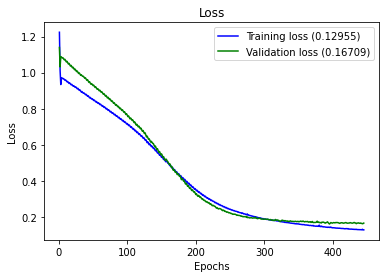

<IPython.core.display.Javascript object>

In [26]:
plot_history(history)

In [27]:
model_auc = mean_absolute_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_valid)).reshape(-1),
    y_true=train[target].values[valid_indices],
)
model_auc

18786.854934210525

<IPython.core.display.Javascript object>

In [28]:
model_auc = mean_squared_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_valid)).reshape(-1),
    y_true=train[target].values[valid_indices],
)
model_auc

1053778786.2717786

<IPython.core.display.Javascript object>

In [29]:
model_auc = mean_absolute_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_test)).reshape(-1),
    y_true=train[target].values[test_indices],
)
model_auc

21055.64747431507

<IPython.core.display.Javascript object>

In [30]:
model_auc = mean_squared_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_test)).reshape(-1),
    y_true=train[target].values[test_indices],
)
model_auc

1496805742.6159458

<IPython.core.display.Javascript object>

In [31]:
from xplainet.model import predict, encode

<IPython.core.display.Javascript object>

In [32]:
probs, explanations = predict(model, input_test)

<IPython.core.display.Javascript object>

In [33]:
probs, encoded_output = encode(model, input_test)

<IPython.core.display.Javascript object>

In [34]:
y_test.shape

(146, 1)

<IPython.core.display.Javascript object>

In [35]:
encoded_output.shape

(146, 384)

<IPython.core.display.Javascript object>

In [36]:
explanations.shape

(146, 80)

<IPython.core.display.Javascript object>

In [37]:
import matplotlib.pyplot as plt

# plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


def explain_plot(importances, columns):
    selection = np.argsort(-np.absolute(importances))[:10]
    # indexes = np.argsort(importances)
    performance = importances[selection]
    #     print(performance.shape)512, 256, 128, 64, 32, 1
    y_pos = np.arange(performance.shape[0])

    plt.barh(y_pos, performance, align="center", alpha=0.5)
    plt.yticks(y_pos, columns[selection])
    # plt.xlabel('Usage')
    plt.title("Feature importance")

    plt.show()

<IPython.core.display.Javascript object>

In [38]:
all_cols = np.array(params["bool_cols"] + params["num_cols"] + params["cat_cols"])
all_cols

array(['Alley', 'Utilities', 'CentralAir', 'Street', 'BsmtFinSF1',
       'GarageYrBlt', 'WoodDeckSF', '1stFlrSF', '2ndFlrSF', 'BsmtUnfSF',
       'Id', 'YearBuilt', 'BsmtFinSF2', 'EnclosedPorch', 'GrLivArea',
       'OpenPorchSF', 'MasVnrArea', 'GarageArea', 'LotArea',
       'YearRemodAdd', 'LotFrontage', 'TotalBsmtSF', 'ScreenPorch',
       'FullBath', 'RoofStyle', 'Exterior1st', 'LotShape', 'MSSubClass',
       'BsmtFinType1', 'Condition2', 'LandSlope', 'GarageCars', 'PoolQC',
       'TotRmsAbvGrd', 'BsmtFullBath', 'MSZoning', 'HalfBath',
       'PavedDrive', 'GarageFinish', 'Exterior2nd', 'LowQualFinSF',
       'HeatingQC', 'MasVnrType', 'Neighborhood', 'GarageType',
       'RoofMatl', 'MiscVal', 'Functional', 'HouseStyle', 'BsmtExposure',
       'OverallQual', 'Fence', 'BsmtFinType2', 'BedroomAbvGr',
       'GarageCond', 'SaleType', 'SaleCondition', 'GarageQual',
       '3SsnPorch', 'Foundation', 'KitchenAbvGr', 'LandContour',
       'FireplaceQu', 'BsmtCond', 'BldgType', 'Condit

<IPython.core.display.Javascript object>

## Explain global

In [39]:
# Looks like this is broken for now.

<IPython.core.display.Javascript object>

In [40]:
probs_train, explanations_train = predict(model, input_train)

<IPython.core.display.Javascript object>

In [41]:
global_explain = np.abs(explanations_train).sum(axis=0)
global_explain = global_explain / np.abs(global_explain).sum()

<IPython.core.display.Javascript object>

In [42]:
global_explain

array([0.0120729 , 0.0124762 , 0.01222614, 0.0124916 , 0.01231679,
       0.01256475, 0.0124518 , 0.01272879, 0.01231033, 0.01235394,
       0.01269806, 0.01338259, 0.01245693, 0.01247649, 0.01324922,
       0.01242439, 0.01251552, 0.01211472, 0.01221215, 0.01256774,
       0.01221374, 0.0116464 , 0.01246198, 0.01276534, 0.01263722,
       0.01249791, 0.01255293, 0.01240453, 0.01246991, 0.01245866,
       0.01253311, 0.01275495, 0.01251976, 0.01265324, 0.01253825,
       0.01236617, 0.01250438, 0.01241296, 0.01251028, 0.01250302,
       0.01250148, 0.01245344, 0.01252493, 0.01272728, 0.01246639,
       0.01256175, 0.01243397, 0.01235894, 0.01246545, 0.01273345,
       0.01275646, 0.01245835, 0.01247271, 0.01254885, 0.01239082,
       0.01259072, 0.01249101, 0.01246913, 0.01249826, 0.01253915,
       0.0124348 , 0.01251683, 0.01263893, 0.01238734, 0.01221684,
       0.01238089, 0.01248622, 0.0125612 , 0.01241776, 0.01247089,
       0.01264738, 0.01247662, 0.01266825, 0.01244678, 0.01258

<IPython.core.display.Javascript object>

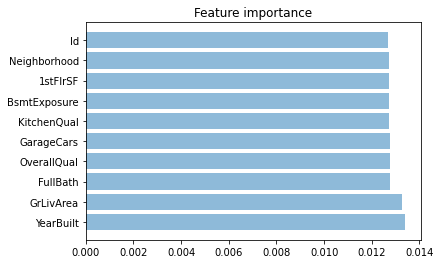

<IPython.core.display.Javascript object>

In [43]:
explain_plot(global_explain, all_cols)

## Explain local

In [44]:
# Looks like this is broken for now.

<IPython.core.display.Javascript object>

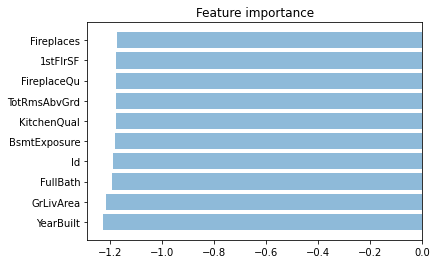

-0.8555428385734558


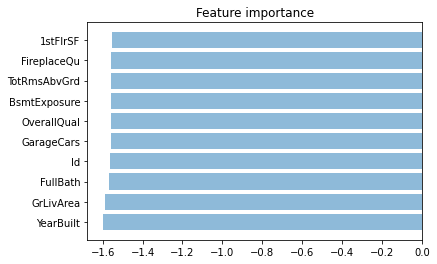

-1.3303014039993286


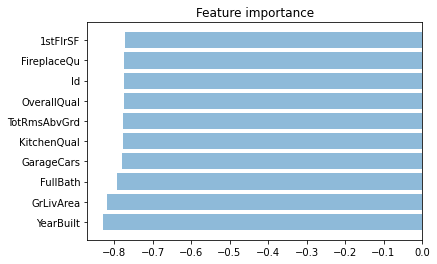

-0.3308514952659607


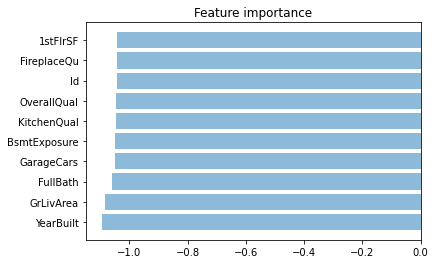

-0.6850005984306335


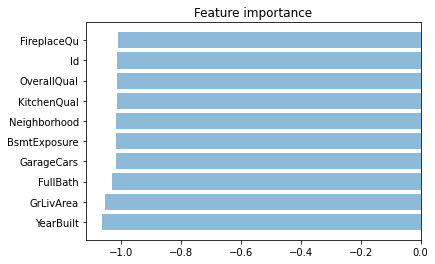

-0.6428357362747192


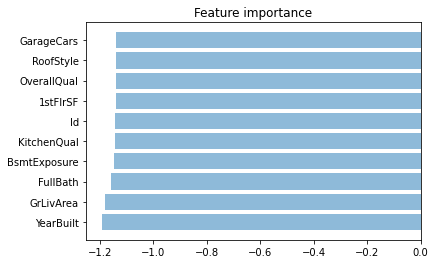

-0.8124862909317017


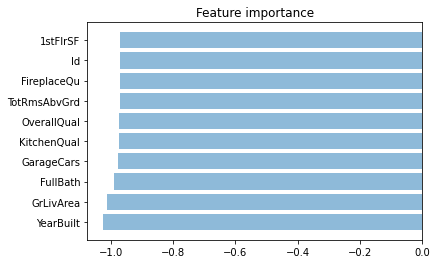

-0.5921539664268494


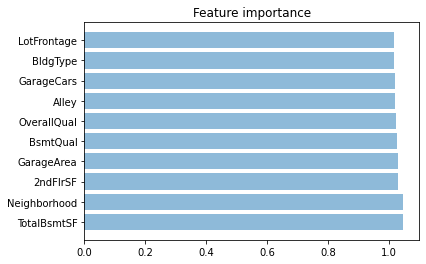

1.865527868270874


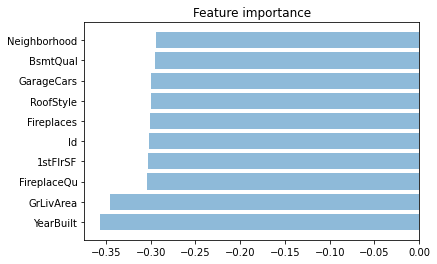

0.2924802899360657


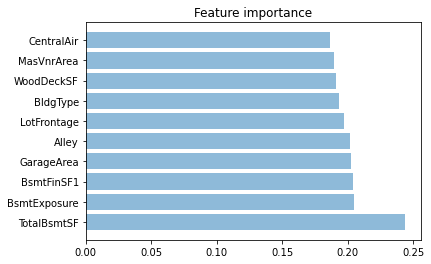

0.8689174652099609


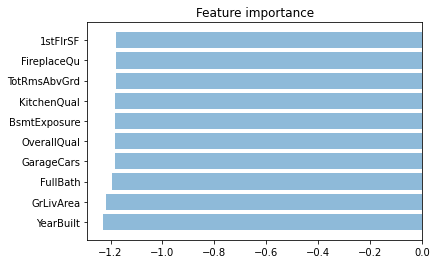

-0.8601822257041931


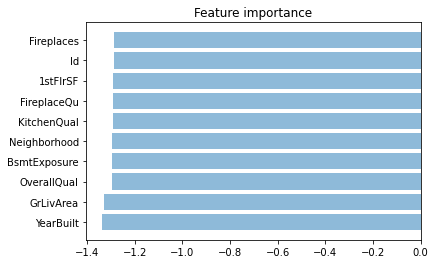

-1.0028027296066284


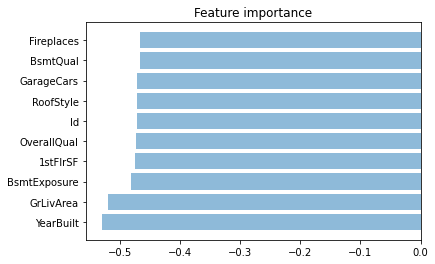

0.06502003222703934


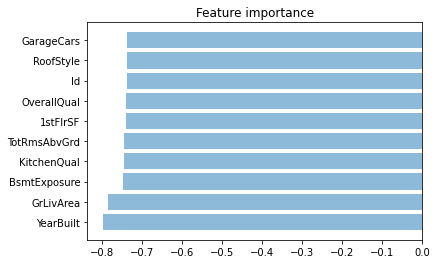

-0.28834038972854614


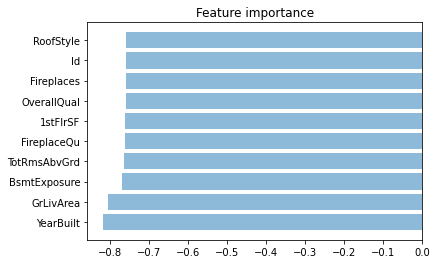

-0.3180586099624634


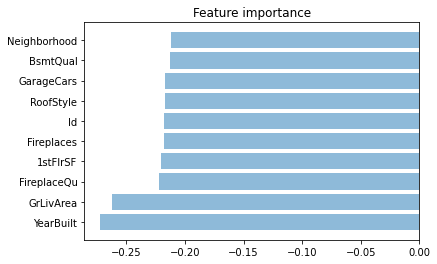

0.40053296089172363


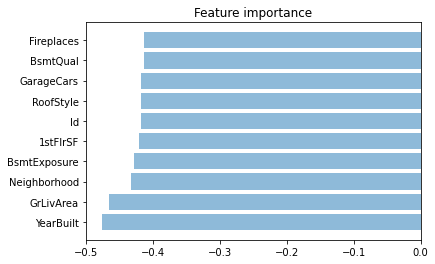

0.13528241217136383


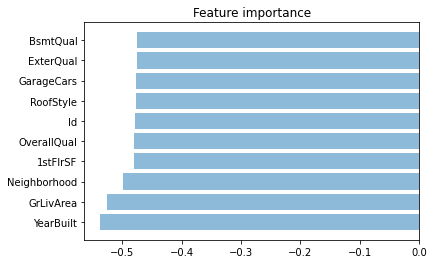

0.05649198219180107


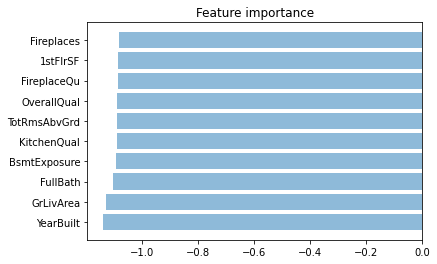

-0.7427381873130798


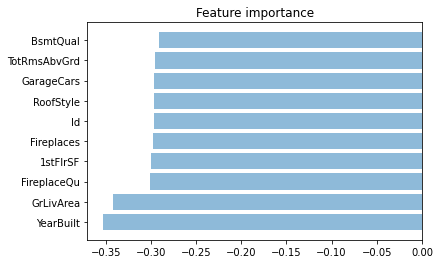

0.29683995246887207


<IPython.core.display.Javascript object>

In [45]:
for i in range(20):
    explain_plot(explanations[i], all_cols)
    print(probs[i].item())

In [46]:
from sklearn.metrics import confusion_matrix

<IPython.core.display.Javascript object>

In [47]:
probs_test, explanations_train = predict(model, input_test)

<IPython.core.display.Javascript object>

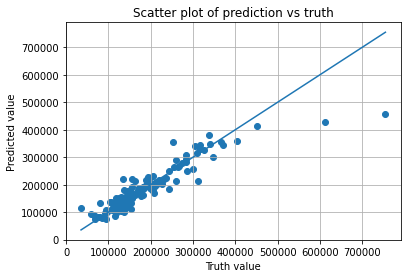

<IPython.core.display.Javascript object>

In [48]:
# plt.barh(y_pos, performance, align="center", alpha=0.5)
# plt.yticks(y_pos, columns[selection])
plt.ylabel("Predicted value")
plt.xlabel("Truth value")

plt.title("Scatter plot of prediction vs truth")
plt.scatter(
    train[target].values[test_indices], target_encoder.inverse_transform(probs_test),
)
plt.plot(
    [
        np.min(train[target].values[test_indices]),
        np.max(train[target].values[test_indices]),
    ],
    [
        np.min(train[target].values[test_indices]),
        np.max(train[target].values[test_indices]),
    ],
)
plt.grid(True)
plt.show()

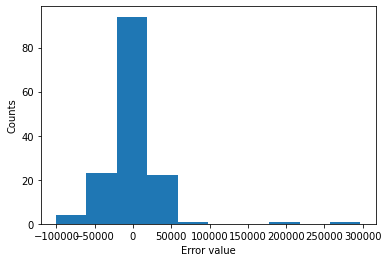

<IPython.core.display.Javascript object>

In [49]:
plt.hist(
    train[target].values[test_indices].reshape(-1)
    - target_encoder.inverse_transform(probs_test).reshape(-1),
)
plt.xlabel("Error value")
plt.ylabel("Counts")
plt.show()

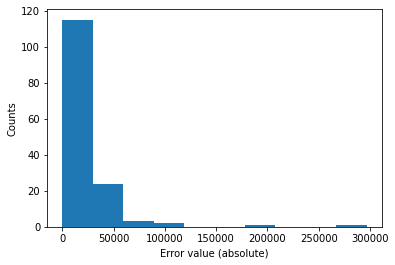

<IPython.core.display.Javascript object>

In [50]:
plt.hist(
    np.abs(
        train[target].values[test_indices].reshape(-1)
        - target_encoder.inverse_transform(probs_test).reshape(-1),
    )
)
plt.xlabel("Error value (absolute)")
plt.ylabel("Counts")
plt.show()

In [51]:
out = Path(os.getcwd() + "/data/" + dataset_name + "-test.csv")

<IPython.core.display.Javascript object>

In [52]:
kaggle_test = train = pd.read_csv(out, sep=",", low_memory=False)

<IPython.core.display.Javascript object>

In [53]:
input_kaggle, _ = preproc_dataset(kaggle_test, target, ["Set"], params)

<IPython.core.display.Javascript object>

In [54]:
probs_kaggle, _ = predict(model, input_kaggle)

<IPython.core.display.Javascript object>

In [55]:
probs_kaggle = target_encoder.inverse_transform(probs_kaggle)

<IPython.core.display.Javascript object>

In [56]:
probs_kaggle

array([[126460.04],
       [172137.7 ],
       [191595.34],
       ...,
       [192870.7 ],
       [103766.74],
       [222555.17]], dtype=float32)

<IPython.core.display.Javascript object>

In [57]:
test_df = kaggle_test[["Id"]]

<IPython.core.display.Javascript object>

In [58]:
test_df["SalePrice"] = probs_kaggle

/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>

In [59]:
test_df.to_csv("kaggle_submit.csv", index=False)

<IPython.core.display.Javascript object>

In [60]:
# Scores 0.18047 on kaggle
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard#score
# Should train with RMSLE ?
# from tensorflow.keras import backend as K

# def root_mean_squared_log_error(y_true, y_pred):
#     return K.sqrt(K.mean(K.square(K.log(1+y_pred) - K.log(1+y_true))))

<IPython.core.display.Javascript object>